# 들어가며

## 목차
___
1. 시퀀스? 시퀀스!
1. I 다음 am을 쓰면 반 이상은 맞더라
1. 실습   
    1) 데이터 다듬기    
    2) 인공지능 학습시키기    
    3) 잘 만들어졌는지 평가하기    
1. 프로젝트 : 멋진 작사가 만들기



# 시퀀스? 시퀀스!

시퀀스는 영화, 전기, 주가, 문장 드라마 등 많은 유형이 시퀀스 데이터에 포함되고, 이를 "sequential"하다고 표현한다.

시퀀스란 데이터를 순서대로 하나씩 나열하여 나타낸 데이터 구조이다. 즉, 순서가 있는 데이터

# I 다음 am을 쓰면 반 이상은 맞더라

인공지능이 글을 이해하게 하는 방식은 통계이다. 문법적인 원리를 통해서가 아니라, **수많은 글을 읽게 함으로써** 결과를 출력한다.

이 방식을 가장 잘 처리하는 인공지능 중 하나가 **RNN**이다. 

`<start>`를 입력으로 받은 신경망은 한 단어를 생성하고, 생성한 단어를 다시 입력으로 사용한다.

## 언어 모델(language model)

n−1개의 단어 시퀀스 W1, W2, ... , Wn-1이 주어졌을 때, n번째 단어 Wn으로 무엇이 올지를 예측하는 확률 모델을 언어 모델(Language Model) 이라고 부른다.



# 실습 (1) 데이터 다듬기

## 데이터 다운로드
```
$ mkdir -p ~/aiffel/lyricist/models
$ ln -s ~/data ~/aiffel/lyricist/data
```

이후 실습에 사용할 라이버리를 불러오자.

In [1]:
import os, re 
import numpy as np
import tensorflow as tf

# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


데이터를 보면, 우리는 화자이름이나 공백뿐인 정보는 원치않는다. 그래서 **필터링**을 통해 우리가 원하는 `문장(대사)`만을 선택하자.

In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


위와 같이 원하는 문장만 출력되었다.

텍스트 분류모델에서 본 것처럼 텍스트 생성 모델에도 단어 사전을 만들게 된다. 그렇다면 문장을 일정한 기준으로 쪼개야한다. 그 과정을 **토큰화**라고 한다.   

**Tokenization**: essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. 

토큰화를 위해 정규표현식을 이용한 필터링을 해보자.

In [83]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


이와 같이, 지저분한 문장을 정제하고 추가로 start와 end를 추가할 수 있게 해주는 함수를 생성하였다.

이제 **소스 문장(Source Sentecne)**과 **타겟 문장(Tareget Sentecne)**를 생성하자!!

위에서 만든 preprocess_setence를 통해서 토큰화를 진행하고, 문장 양쪽에 붙은 `<start>`와 `<end>`를 각각 제거해주면 된다!



In [4]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

데이터는 준비가 되었다. 이제 컴퓨터가 이해할 수 있게 **숫자로 바꿔주어야 한다**.

어떻게 숫자로 바꿔줄까??

텐서플로우는 자연어 처리를 위한 여러 모듈을 제공하는데, 그 중 `tf.keras.preprocesssing.text.Tokenizer` 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary, ditionary)을 만들어주고, **데이터를 숫자로 변환까지 해준다.** 이 과정을 **벡터화(vectorize)**라고 하며, 숫자로 변환된 데이터를 **텐서**라고 부른다. **우리가 사용하는 텐서플로 모델의 입출력 데이터는 모두 텐서로 변환되어 처리된다!**

**Vectorization**: the process of converting text into numerical representation.


In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ', # filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' 와 같이 들어갈 수 있다

        oov_token="<unk>" # oov_token means out out vocabulary tokens used to replace unknown words.
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤(=post)에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)
tokenizer

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fa047fdefd0>


위 코드에 대해 공부를 하다가 패딩이 seq길이를 일정하게 맞춰준다는 점에서 궁금증이 생겼다. 그건 바로 왜 sequence길이가 일정해야 하는가였다. 그에 대한 해답은 다음과 같다:    
 Naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary..   

 When a sentence exceeds the number of max words, then it will drop the words and by default setting, it will drop the words at the beginning of the sentence.
 

In [6]:
# 예시 출력
print(tensor[:3, :10])

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]
1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


이렇게 텐서 데이터는 모두 정수로 이뤄져 있으며, end 토큰(3) 이후에 있는 0들은 모두 padding으로 잘 채워진 것이다.

In [7]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


소스 input은 양쪽에 start, end 토큰이 있고,
target으로 사용하기 위한 tgt_input은 start 토큰(2)이 제거된 것을 확인할 수 있다!

마지막으로 데이터셋 객체를 생성하자. 그동안의 학습에서는 model.fit 형태로 Numpy Array 데이터셋을 생성하여 model에 제공하는 학습을 진행해 왔다. 하지만 텐서플로우를 활용할 때는`텐서로 생성된 데이터`를 이용해 `tf.data.Dataset`객체를 생성하는 방법을 많이 사용한다. `tf.data.Dataset` 객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선과 여러 편의 기능을 제공하므로 꼭 사용법을 알아두자!

위에서 데이터셋을 텐서 형태로 생성해두었으므로, `tf.data.Dataset.from_tensor_slices()` 메소드를 활용해 `tf.data.Dataset`객체를 생성하자.

In [8]:
BUFFER_SIZE = len(src_input)
print(BUFFER_SIZE)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

24015


<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

이번 step에서 데이터셋을 생성하기 위해 거친 과정을 꼭 잘 기억해두자!!

- 정규표현식을 이용한 corpus 생성
- `tf.keras.preprocessing.text.Tokenizer`를 통해 corpus를 텐서로 변환
- corpus 텐서를 `tf.data.Dataset` 객체로 변환(with `tf.data.Dataset.from_tensor_slices()`)

이렇게 `dataset`을 얻음으로써 데이터 다듬기가 끝났다. 이제 tf.data.Dataset에서 제공하는 shuffle(), batch()등의 데이터셋 관련 기능들을 사용할 수 있게 되었다.

이 모든 과정을 **텐서플로우에서의 데이터 전처리**라고 한다.

## 실습 (2) 인공지능 학습시키기

오늘 만들어볼 모델의 구조는 다음 그림과 같다.

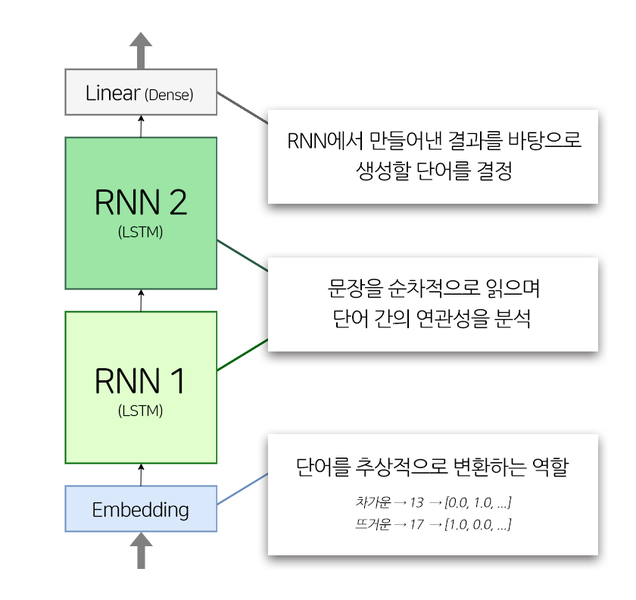

모델은 tf.keras.Model을 Subclassing하는 방식으로 만들 것이다.

1개의 emebedding layer, 2개의 LSTM layer, 1개의 Dense 레이어로 구성되어 있다.


In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256 #단어가 추상적으로 표현되는 크기
hidden_size = 1024 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

입력 텐서에는 단어 사전의 인덱스가 들어가 있다. Embedding layer는 이 인덱스 값들을 해당 인덱스 번째의 워드 벡터로 바꿔준다. 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용된다.
### `Q 아직 이게 어떤 의민지 이해못했다. 다시 볼것`


아직 모델은 제대로 builld되지 않았다. 그렇기에 아래와 같이 model에 데이터를 조금만 태우는 것도 좋은 방법이다. 왜냐하면 model의 input shape가 결정되면서 model.build()가 자동으로 호출되기 때문이다.

In [13]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample) # shape = (256,20,7001)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[ 1.3798405e-06,  5.3323552e-06,  1.6405660e-04, ...,
          3.8993378e-05, -1.9098781e-05, -1.6986892e-04],
        [-2.8383578e-04,  4.7941454e-04,  1.0153956e-04, ...,
          1.3352025e-04,  2.2641751e-04, -2.7227832e-04],
        [-2.3777767e-04,  6.8196171e-04, -6.0441230e-06, ...,
          2.9101301e-04,  2.4756228e-04, -5.0735677e-04],
        ...,
        [ 2.5167945e-04,  3.1150630e-04,  1.1066822e-03, ...,
          5.4239400e-04,  3.3596766e-04, -9.3612063e-04],
        [ 1.6229293e-04,  4.4400815e-04,  1.7472004e-03, ...,
          6.2526442e-04,  2.8334200e-04, -4.8326206e-04],
        [ 6.8543886e-05,  5.6774111e-04,  2.3910762e-03, ...,
          7.8269321e-04,  1.7909952e-04, -6.3338164e-05]],

       [[ 1.3798405e-06,  5.3323552e-06,  1.6405660e-04, ...,
          3.8993378e-05, -1.9098781e-05, -1.6986892e-04],
        [-3.0567331e-04,  1.5853932e-04,  1.7777552e-04, ...,
          3.2005697e-05,  

모델의 최종 출력 텐서 모양을 보면, (256,20,7001)을 확인할 수 있다. 7001은 dense layer의 출력 차원수이고, 256은 이전 스텝에서 지정해준 batch_size이다. 즉, 1개의 배치(=256개의 문장 데이터)를 가져왔기 때문이다.

그렇다면 여기서 20은 무엇을 의미하는지 궁금해질 것이다. 이는 `tf.keras.layer.LSTM(hidden_size, return_sequences=True)`로 호출한 LSTM레이어에서, `return_sequences=True`라고 지정한 부분에 있다. 이는 **자신에게 입력된 시퀀스 길이만큼과 동일한 길이의 시퀀스를 출력한다**
(`return_sequences=False`라면 LSTM layer는 1개의 벡터만 출력한다)

그렇다면 모델을 만들때조차 알려준 적도 없는 20이라는 seq_len은 언제 알게 된 것일까? **바로 데이터를 입력받으면서 알게 된 것이다!**
데이터셋의 max_len이 20으로 맞춰져 있었기 때문이다.

In [14]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1792256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


이제 모델을 학습시켜보자.

In [16]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 19s 184ms/step - loss: 2.2582
Epoch 2/30
93/93 [==============================] - 17s 185ms/step - loss: 2.1632
Epoch 3/30
93/93 [==============================] - 17s 185ms/step - loss: 2.1046
Epoch 4/30
93/93 [==============================] - 17s 185ms/step - loss: 2.0425
Epoch 5/30
93/93 [==============================] - 17s 184ms/step - loss: 1.9760
Epoch 6/30
93/93 [==============================] - 17s 184ms/step - loss: 1.9059
Epoch 7/30
93/93 [==============================] - 17s 184ms/step - loss: 1.8324
Epoch 8/30
93/93 [==============================] - 17s 184ms/step - loss: 1.7572
Epoch 9/30
93/93 [==============================] - 17s 185ms/step - loss: 1.6804
Epoch 10/30
93/93 [==============================] - 17s 186ms/step - loss: 1.6050
Epoch 11/30
93/93 [==============================] - 17s 185ms/step - loss: 1.5292
Epoch 12/30
93/93 [==============================] - 17s 185ms/step - loss: 1.4561
Epoch 13/30
9

## 실습 (3) 잘 만들어졌는지 평가하기
이제 작문을 시켜보고 직접 평가해보자. 아래 `generate_text`함수는 시작 문장이 전달되면, 시작 문장을 바탕으로 작문이 진행된다.

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

코드를 보면 while문을 통해 돌아가고 있음을 확인할 수 있다. 학습 단계에서는 이런 while문이 필요가 없었지만 지금은 왜 필요할까??

왜냐하면, 학습 단계에서는 소스 문장과 타겟 문장이 있었고, 소스 문장을 모델에 입력해서 나온 결과를 타켓 문장과 직접 비교하면 그만이었다. 하지만, **텍스트를 실제로 생성하는 현재는, `타겟문장`과 `소스문장`이 없다.**   
그렇기에 generate_text()함수에서 init_sentence를 인자로 받고 있고, 이렇게 받은 인자를 텐서로 만들고 루프를 돌면서 들어간다.

실제로 문장이 생성되는지 살펴보자.

In [20]:
generate_text(model, tokenizer, init_sentence="<start> they")

'<start> they are but lewis and warwick i am edward , <end> '

___

# 프로젝트: 작사가 만들기

## step1: data download


이미 실습에서 심볼릭 링크로 데이터를 생성했기 때문에, 상관없다.

## step2: reading data

`glob` 모듈을 사용하면 파일을 읽어오는 작업을 하기 유용하다. glob을 활용해 모든 txt파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하자.

In [84]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:10])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth', 'The minor fall, the major lift', 'The baffled king composing Hallelujah Hallelujah', 'Hallelujah', 'Hallelujah', 'Hallelujah Your faith was strong but you needed proof']


## step3: 데이터 정제
**앞서 배운 테크닉을 통해 문장 생성에 적합한 모양으로 데이터를 정제하라!**
`preprocess_sentence()` 함수를 통해 데이터를 정제하자.

추가로 지나치게 긴 문장은 제거하자. **토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기**를 권한다.

In [129]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r"  ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    num_words = len(sentence.split(" "))
    if num_words > 10: continue 
        
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        

print("데이터 크기:", len(corpus))
print("Examples:\n", corpus[:3])        
        
# 정제된 결과를 확인
corpus[:3]
print( max(corpus, key=len) )


데이터 크기: 141586
Examples:
 ['<start> now i ve heard there was a secret chord <end>', '<start> that david played and it pleased the lord <end>', '<start> but you don t really care for music do you <end>']
<start> ah yeah yeah yeah yeah yeah yeah everything changed me we re not the only ones <end>


## step4: 평가 데이터셋 분리
`tokenizer()`함수로 데이터를 Tensor로 변환한 후, `sklearn`모듈의 `train_test_split()`함수를 이용해 분리하자.

**단어장의 크기는 12,000 이상** & **총 데이터의 20%를 평가 데이터셋으로 사용**

In [130]:
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words= 12000, 
        filters=' ', # 걸러낼 문자리스트 적어준다. default는'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'이다.

        oov_token="<unk>" # oov_token means out out vocabulary tokens used to replace unknown words.
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤(=post)에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

In [131]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    


In [132]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          random_state=3)

enc_train.shape, enc_val.shape, dec_train.shape, dec_val.shape

((113268, 22), (28318, 22), (113268, 22), (28318, 22))

## step5: 인공지능 만들기
모델의 Embedding Size와 Hidden Size를 조절하며 10 epoch 안에 **`val_loss`값을 2.2 이하로 나오게 모델을 설계(loss 함수 유지)**


In [134]:
#하이퍼 파라미터

BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 22), (256, 22)), types: (tf.int32, tf.int32)>

In [135]:
# 모델

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256 #단어가 추상적으로 표현되는 크기
hidden_size = 1024 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [136]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=10)

Epoch 1/10
442/442 [==============================] - 117s 255ms/step - loss: 2.1183
Epoch 2/10
442/442 [==============================] - 114s 257ms/step - loss: 1.7806
Epoch 3/10
442/442 [==============================] - 114s 256ms/step - loss: 1.6897
Epoch 4/10
442/442 [==============================] - 114s 257ms/step - loss: 1.6170
Epoch 5/10
442/442 [==============================] - 114s 257ms/step - loss: 1.5539
Epoch 6/10
442/442 [==============================] - 114s 258ms/step - loss: 1.4958
Epoch 7/10
442/442 [==============================] - 114s 257ms/step - loss: 1.4415
Epoch 8/10
442/442 [==============================] - 114s 258ms/step - loss: 1.3913
Epoch 9/10
442/442 [==============================] - 114s 258ms/step - loss: 1.3451
Epoch 10/10
442/442 [==============================] - 114s 257ms/step - loss: 1.3022


In [137]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=22):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [160]:
generate_text(model, tokenizer, init_sentence="<start> my girl ", max_len=20)

'<start> my girl went through my cell phone <end> '


# 회고
    
 1. 이번 프로젝트에서 **어려웠던 점,**
- 크게 어려웠던 점은 없었던 것 같다. 프로젝트를 시작하기 전에 개념이 명확히 잡히지 않아서 프로젝트를 늦게 시작했다. 프로젝트 이전의 내용들을 3회씩 보면서 개념을 정리하면서 이해하려고 하였고, 그 후에 프로젝트를 시작하니 아주 괜찮았던 것 같다!

   
 2. 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.   
  - tf.data.Dataset에 대해서 조금 헷갈렸었는데, 구글에서 이것저것 찾아보면서 더 이해가 되었다.
  - Embedding layer에 대해 정확히 이해가 가지 않았고, 아직도 잘은 모르겠다.


 3. 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
   - len(sentence)를 바꿔서 토큰 길이를 맞추기 위해 노력했다.
   - RNN 기본 개념에 대해서 정말 많이 이해하려했다.


 4. 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
   - 잘 모르겠다. 1번 평가문항에서 제네레이션 결과가 그럴듯한 문장으로 생성된 게 기준이 모호한 것 같다. 문법상 오류가 없으면 되는지, 상황상 맞아야 하는지 모르겠다.
   
 5. **자기 다짐**
   - 공부 방법에 대해서 조금 더 고민해봐야할 것 같다! 이전에 아리쏭하면서 했던 프로젝트와 달리, 그 이전을 꼼꼼하게 짚고 프로젝트를 시작하니 오히려 시간이 더 짧게 되고, 공부도 정확한 느낌이 들었다. 다음 노드도 이렇게 해봐야겠다!
   - 이것저것 시험도 보고, 대외활동도 하느라 한껏 바쁘지만, 더 열심히 해야겠다! 그리고 노는 시간, 자는 시간을 줄여야겠다.
  